# Client Retention and Gender Analysis

This notebook analyzes the `clients_months.csv` dataset to understand client retention, gender distribution, and gym attendance frequency.

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

In [42]:
# Load the dataset
df = pd.read_csv('../data/04-processed/gym_routines_by_month.csv')

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'], format='%m/%Y')

# Display first few rows
df.head()

,client_id,date,gender,day
0,0,2023-01-01,M,1
1,0,2022-08-01,M,1
2,0,2022-09-01,M,1
3,0,2022-11-01,M,1
4,1,2024-01-01,M,3


In [43]:
# I will filter the first month because it has only 2 routines
print(f"Rows before filter: {df.shape[0]}")
df = df[df['date'] != '2022-07']
print(f"Rows after filter: {df.shape[0]}")

Rows before filter: 3127
Rows after filter: 3125


## 1. Gender Analysis

Let's look at the distribution of clients by gender.

C:\Users\alejo\AppData\Local\Temp\ipykernel_10036\3797613857.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='gender', order=['F', 'M'], palette={'F': 'salmon', 'M': 'skyblue'})


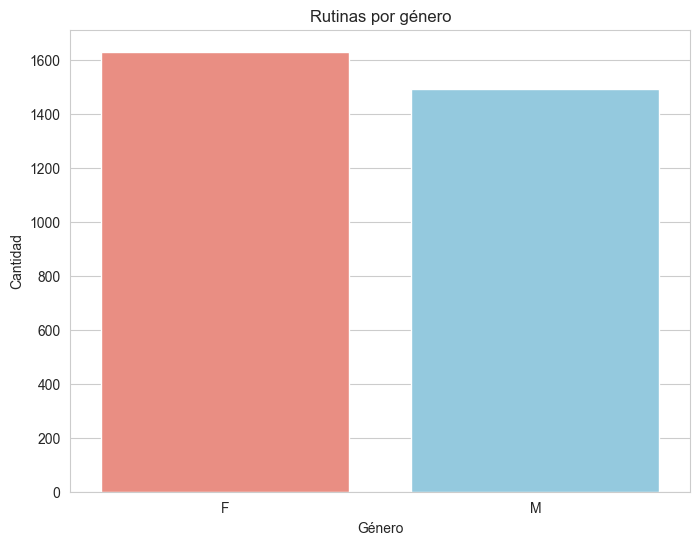

In [62]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='gender', order=['F', 'M'], palette={'F': 'salmon', 'M': 'skyblue'})
plt.title('Rutinas por género')
plt.xlabel('Género')
plt.ylabel('Cantidad')
plt.show()

Unique clients by gender:
gender
F    332
M    273
Name: count, dtype: int64


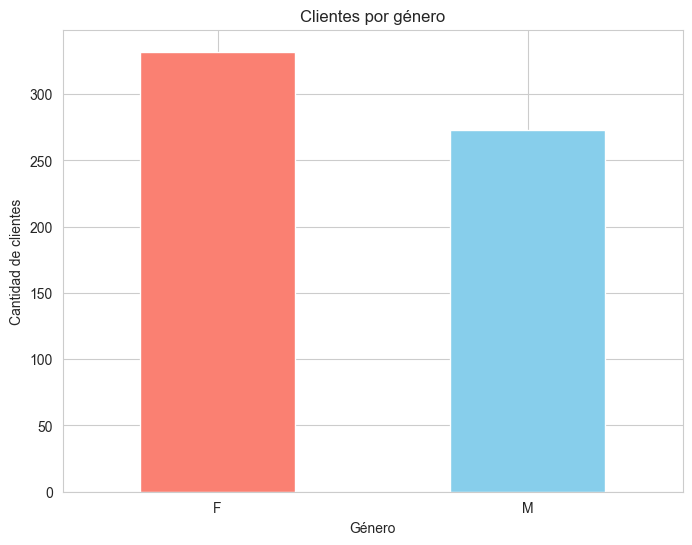

In [45]:
# Unique clients by gender
unique_clients_gender = df.drop_duplicates(subset=['client_id'])['gender'].value_counts()
print("Unique clients by gender:")
print(unique_clients_gender)

plt.figure(figsize=(8, 6))
unique_clients_gender.plot(kind='bar', color=['salmon', 'skyblue'])
plt.title('Clientes por género')
plt.xlabel('Género')
plt.ylabel('Cantidad de clientes')
plt.xticks(rotation=0)
plt.show()

## 2. Retention Analysis (Cohort Analysis)

We will perform a cohort analysis to track client retention over time. 
A cohort is defined as a group of users who started their activity in the same month.

In [46]:
# 1. Assign cohort month (first month of activity for each client)
df['cohort_month'] = df.groupby('client_id')['date'].transform('min')

# 2. Calculate cohort index (number of months since start)
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year, month

activity_year, activity_month = get_date_int(df, 'date')
cohort_year, cohort_month = get_date_int(df, 'cohort_month')

years_diff = activity_year - cohort_year
months_diff = activity_month - cohort_month

df['cohort_index'] = years_diff * 12 + months_diff + 1

# 3. Count monthly active customers from each cohort
grouping = df.groupby(['cohort_month', 'cohort_index'])
cohort_data = grouping['client_id'].apply(pd.Series.nunique).reset_index()

# 4. Create pivot table
cohort_counts = cohort_data.pivot(index='cohort_month', columns='cohort_index', values='client_id')

# 5. Calculate retention rate
cohort_sizes = cohort_counts.iloc[:, 0]
retention = cohort_counts.divide(cohort_sizes, axis=0)

# Format index for better readability in plot
retention.index = retention.index.strftime('%Y-%m')

retention.fillna(0, inplace=True)
retention.head()

cohort_index,1,2,3,4,5,6,7,8,9,10,...,32,33,34,35,36,37,38,39,40,41
cohort_month,,,,,,,,,,,,,,,,,,,,,
2022-08,1.0,0.405405,0.729730,0.513514,0.297297,0.324324,0.243243,0.378378,0.405405,0.486486,...,0.108108,0.162162,0.108108,0.054054,0.054054,0.162162,0.135135,0.108108,0.108108,0.054054
2022-09,1.0,0.714286,0.428571,0.142857,0.500000,0.142857,0.214286,0.142857,0.142857,0.071429,...,0.000000,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.000000,0.071429,0.000000
2022-10,1.0,0.533333,0.466667,0.333333,0.266667,0.200000,0.266667,0.466667,0.400000,0.466667,...,0.133333,0.133333,0.200000,0.200000,0.266667,0.000000,0.200000,0.133333,0.000000,0.000000
2022-11,1.0,0.461538,0.384615,0.307692,0.076923,0.153846,0.153846,0.153846,0.153846,0.230769,...,0.076923,0.000000,0.076923,0.000000,0.076923,0.000000,0.076923,0.000000,0.000000,0.000000
2022-12,1.0,0.333333,0.333333,0.333333,0.000000,0.333333,0.222222,0.222222,0.222222,0.222222,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


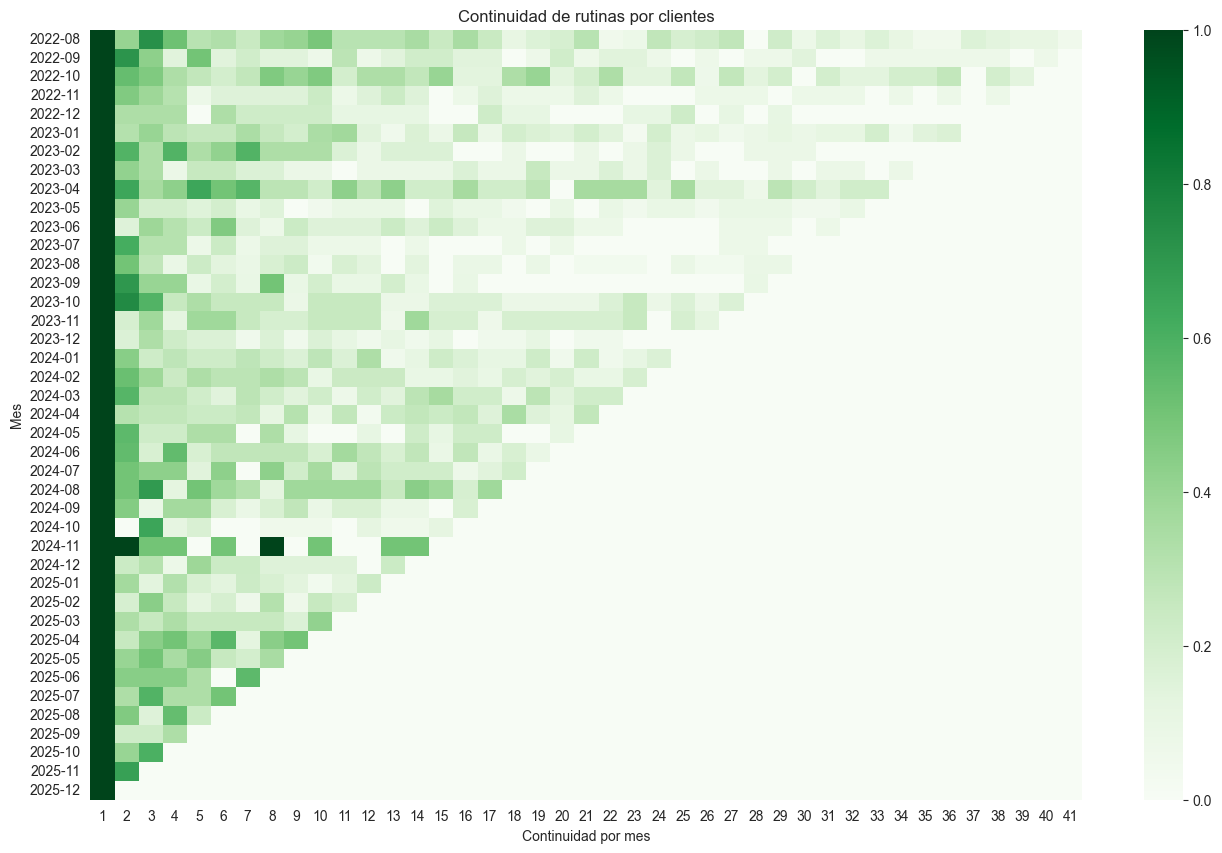

In [47]:
plt.figure(figsize=(16, 10))
sns.heatmap(retention, fmt='.0%', cmap='Greens')
plt.title('Continuidad de rutinas por clientes')
plt.ylabel('Mes')
plt.xlabel('Continuidad por mes')
plt.show()

## Retention by gender

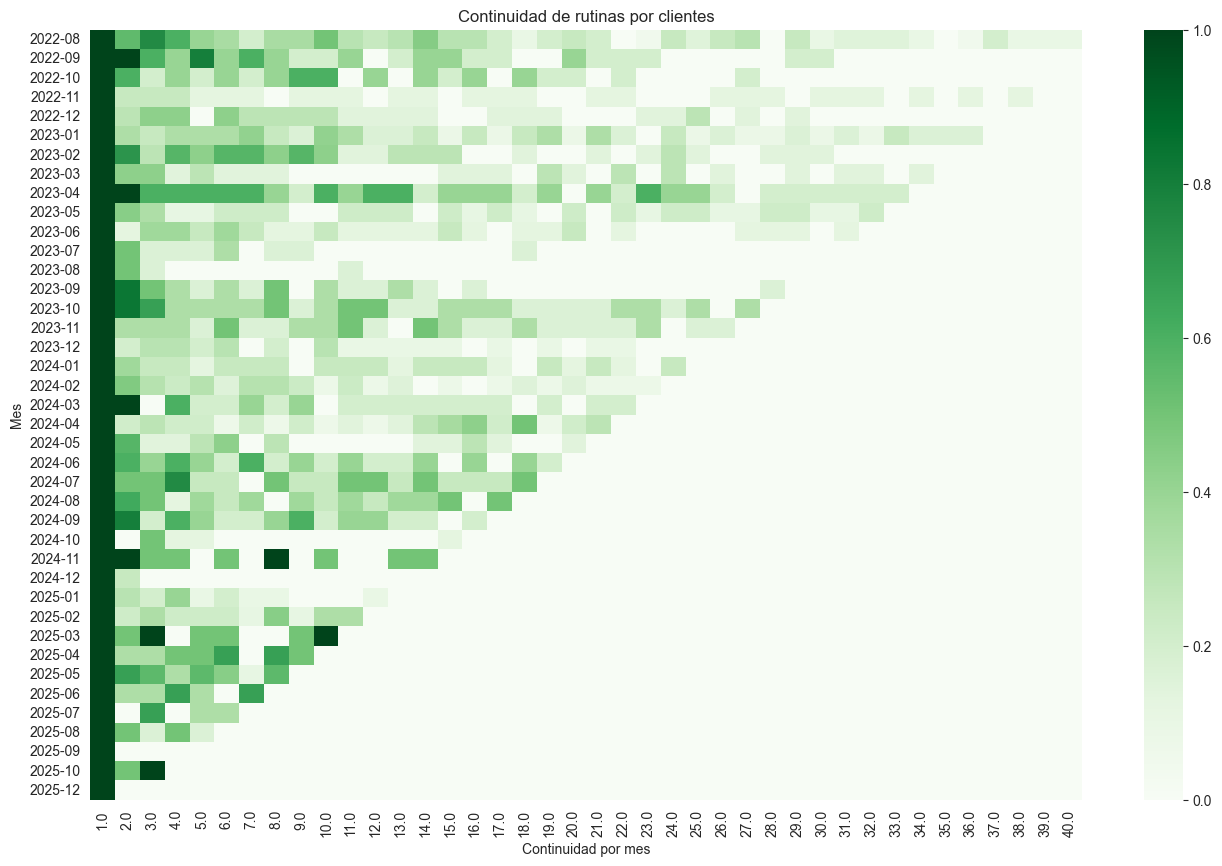

In [48]:
# 1. Assign cohort month (first month of activity for each client)
df['cohort_month'] = df[df["gender"] == "M"].groupby('client_id')['date'].transform('min')

# 2. Calculate cohort index (number of months since start)
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year, month

activity_year, activity_month = get_date_int(df, 'date')
cohort_year, cohort_month = get_date_int(df, 'cohort_month')

years_diff = activity_year - cohort_year
months_diff = activity_month - cohort_month

df['cohort_index'] = years_diff * 12 + months_diff + 1

# 3. Count monthly active customers from each cohort
grouping = df.groupby(['cohort_month', 'cohort_index'])
cohort_data = grouping['client_id'].apply(pd.Series.nunique).reset_index()

# 4. Create pivot table
cohort_counts = cohort_data.pivot(index='cohort_month', columns='cohort_index', values='client_id')

# 5. Calculate retention rate
cohort_sizes = cohort_counts.iloc[:, 0]
retention = cohort_counts.divide(cohort_sizes, axis=0)

# Format index for better readability in plot
retention.index = retention.index.strftime('%Y-%m')

retention.fillna(0, inplace=True)

plt.figure(figsize=(16, 10))
sns.heatmap(retention, fmt='.0%', cmap='Greens')
plt.title('Continuidad de rutinas por clientes')
plt.ylabel('Mes')
plt.xlabel('Continuidad por mes')
plt.show()

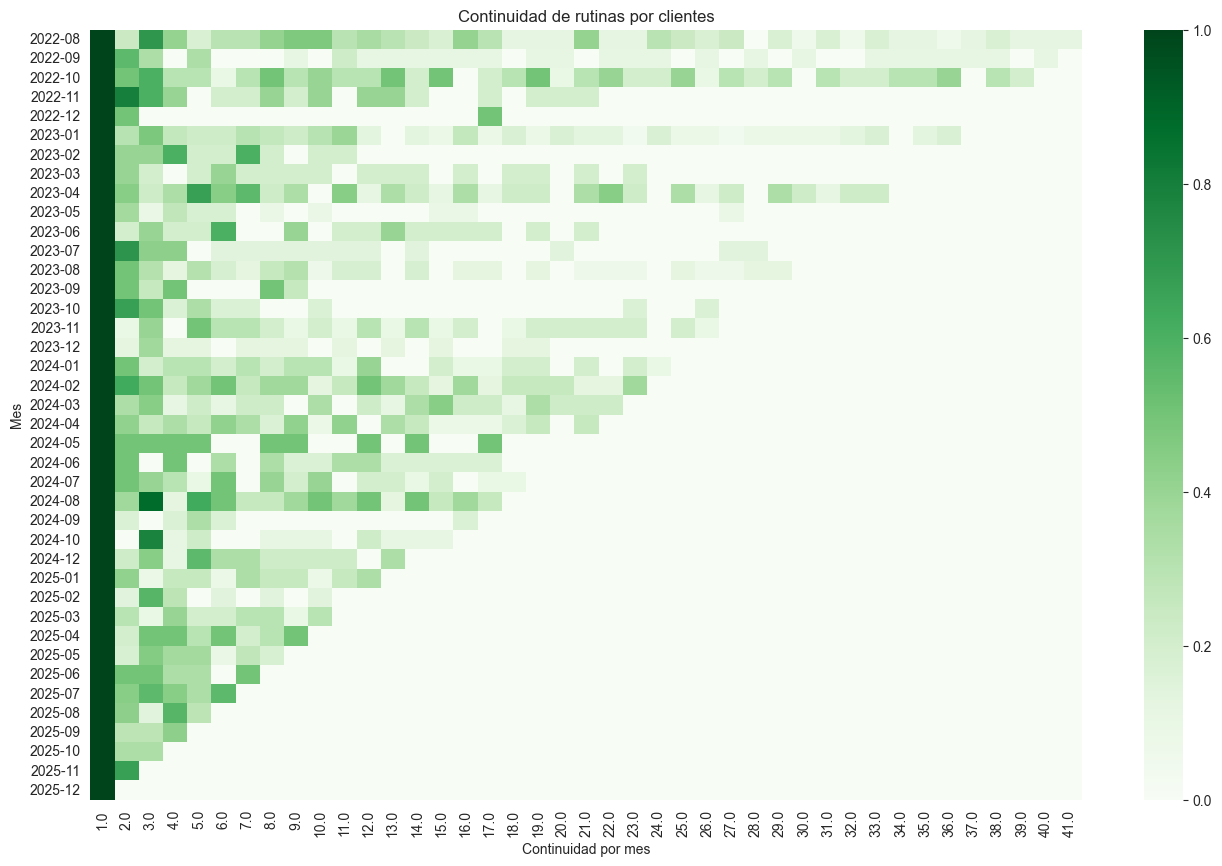

In [49]:
# 1. Assign cohort month (first month of activity for each client)
df['cohort_month'] = df[df["gender"] == "F"].groupby('client_id')['date'].transform('min')

# 2. Calculate cohort index (number of months since start)
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year, month

activity_year, activity_month = get_date_int(df, 'date')
cohort_year, cohort_month = get_date_int(df, 'cohort_month')

years_diff = activity_year - cohort_year
months_diff = activity_month - cohort_month

df['cohort_index'] = years_diff * 12 + months_diff + 1

# 3. Count monthly active customers from each cohort
grouping = df.groupby(['cohort_month', 'cohort_index'])
cohort_data = grouping['client_id'].apply(pd.Series.nunique).reset_index()

# 4. Create pivot table
cohort_counts = cohort_data.pivot(index='cohort_month', columns='cohort_index', values='client_id')

# 5. Calculate retention rate
cohort_sizes = cohort_counts.iloc[:, 0]
retention = cohort_counts.divide(cohort_sizes, axis=0)

# Format index for better readability in plot
retention.index = retention.index.strftime('%Y-%m')

retention.fillna(0, inplace=True)

plt.figure(figsize=(16, 10))
sns.heatmap(retention, fmt='.0%', cmap='Greens')
plt.title('Continuidad de rutinas por clientes')
plt.ylabel('Mes')
plt.xlabel('Continuidad por mes')
plt.show()

## 3. Days per Routine Analysis

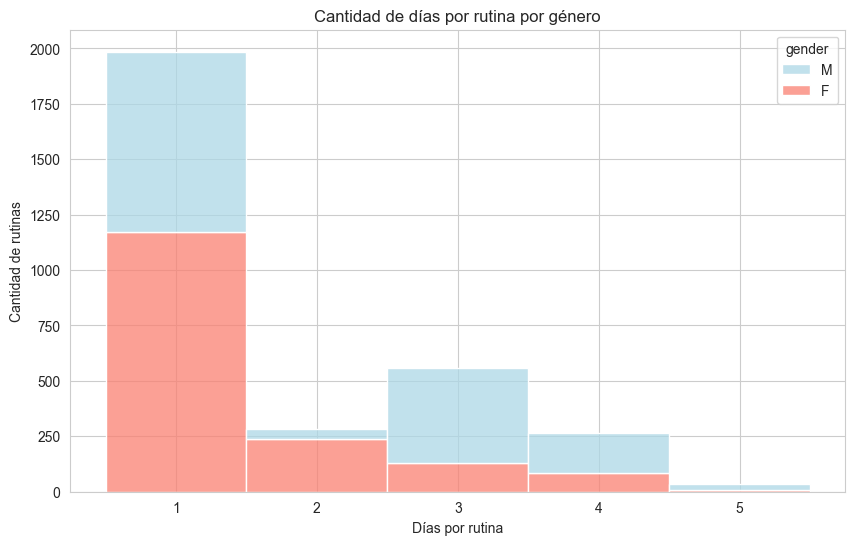

In [64]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='day', hue='gender', discrete=True, multiple='stack', palette={'F': 'salmon', 'M': 'lightblue'})
plt.title('Cantidad de días por rutina por género')
plt.xlabel('Días por rutina')
plt.ylabel('Cantidad de rutinas')
plt.xticks(range(1, 6))
plt.show()

## 4. Count by Date

Here we visualize the number of active client records per month.

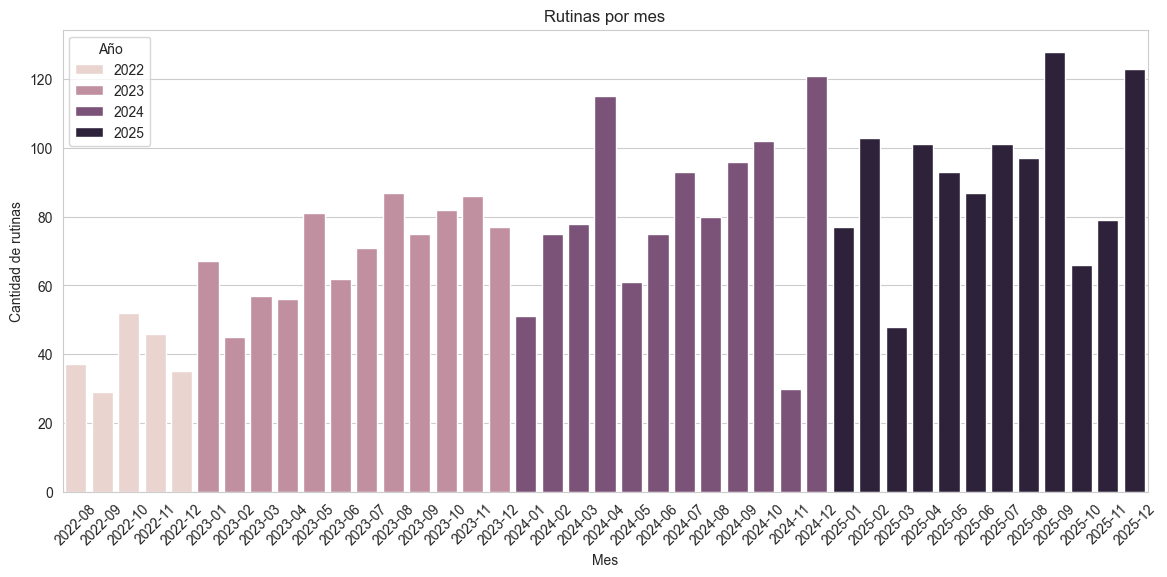

In [57]:
plt.figure(figsize=(14, 6))
# Format dates as strings for the x-axis labels to be cleaner
df['date_str'] = df['date'].dt.strftime('%Y-%m')
df['year'] = df['date'].dt.year
sns.countplot(data=df.sort_values('date'), x='date_str', hue='year', dodge=False)
plt.title('Rutinas por mes')
plt.legend(title='Año')
plt.xlabel('Mes')
plt.ylabel('Cantidad de rutinas')
plt.xticks(rotation=45)
plt.show()

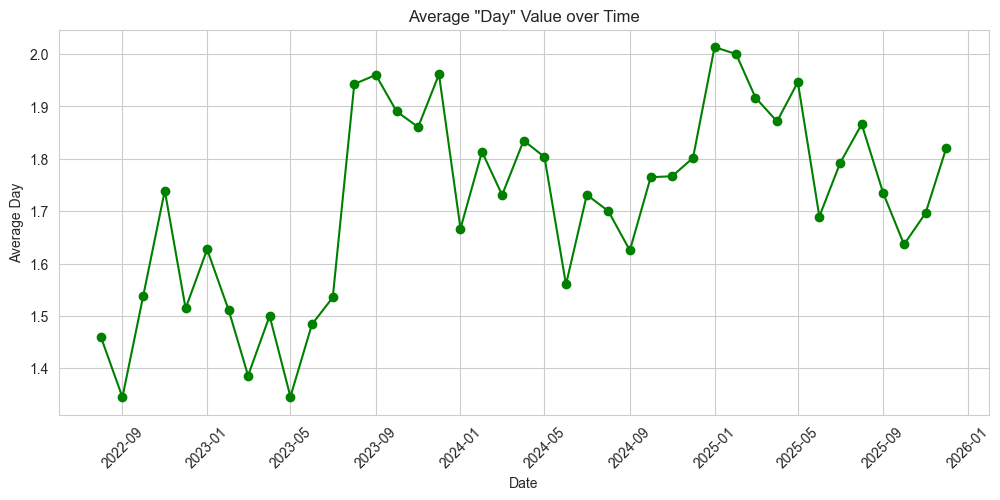

In [ ]:
plt.figure(figsize=(12, 5))
avg_day_per_month = df.groupby('date')['day'].mean()
plt.plot(avg_day_per_month.index, avg_day_per_month.values, marker='o', color='green')
plt.title('Average "Day" Value over Time')
plt.xlabel('Date')
plt.ylabel('Average Day')
plt.xticks(rotation=45)
plt.grid(True)

# Number of clients per year

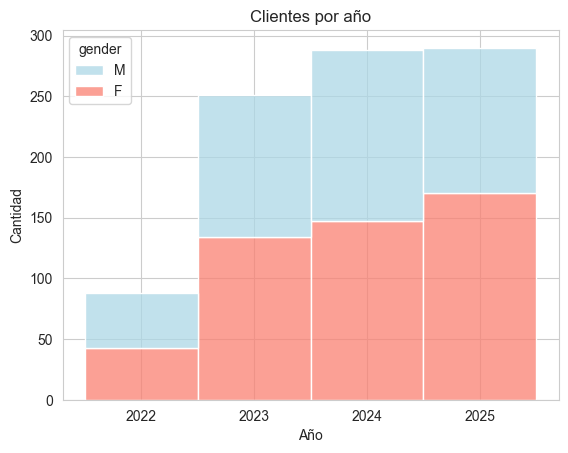

In [60]:
clients_by_year = df.drop_duplicates(subset=['year', 'client_id'])
sns.histplot(data=clients_by_year, x='year', discrete=True, hue="gender", palette={'F': 'salmon', 'M': 'lightblue'}, multiple="stack")

plt.title('Clientes por año')
plt.xlabel('Año')
plt.ylabel('Cantidad')
plt.xticks(sorted(clients_by_year['year'].unique()))
plt.show()

# Routines per client

In [54]:
routines_per_client = df.groupby(["client_id", "gender"])["date"].count().reset_index(name="count")

In [55]:
routines_per_client

,client_id,gender,count
0,0,M,4
1,1,M,28
2,2,M,6
3,3,F,32
4,4,M,19
...,...,...,...
600,604,F,1
601,605,F,1
602,606,F,3
603,607,F,7


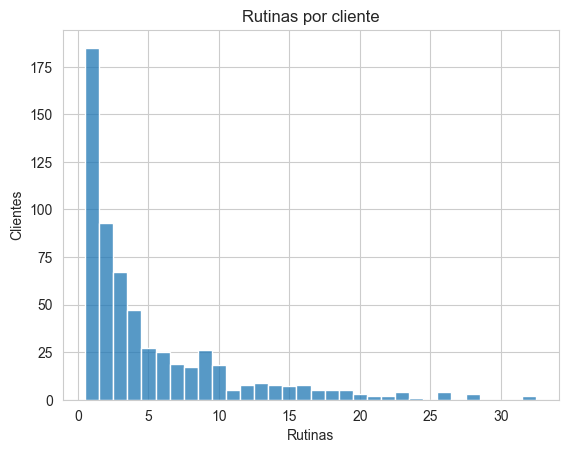

In [56]:
sns.histplot(data=routines_per_client, x="count", discrete=True, multiple="stack")
plt.title("Rutinas por cliente")
plt.xlabel("Rutinas")
plt.ylabel("Clientes")
plt.show()